In [ ]:
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import rioxarray
from pyproj import CRS
from rasterio.enums import Resampling
from affine import Affine

In [101]:
date = input("Enter date (YYYY-MM-DD): ")
init_hour = int(input("Enter initialization hour (HH): "))
forecast = int(input("Enter forecast hour (0..N): "))

# Build the HRRR cycle datetime (initialization time)
cycle_dt = datetime.fromisoformat(f"{date} {init_hour:02d}:00")

# Compute the forecast valid time (handles day/month/year rollovers)
valid_dt = cycle_dt + timedelta(hours=forecast)

# Optional: a display string if you need it
displayhour = valid_dt.strftime("%H:%M")

# Compute display hour safely
displayhour = (forecast + init_hour) % 24

# HRRR: pass the cycle time + forecast hour
hrrr = Herbie(
    cycle_dt,
    model="hrrr",
    product="sfc",
    fxx=forecast
)

# RTMA: pass the *valid* analysis time so it matches HRRR's valid time
rtma = Herbie(
    valid_dt,
    model="rtma",
    product="anl"
)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Nov-12 12:00 UTC F08 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=rtma ┊ product=anl ┊ 2025-Nov-12 20:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [108]:
ds_hrrr = hrrr.xarray("TMP:2 m above")
ds_rtma = rtma.xarray("TMP:2 m above")

In [109]:
# --- YOUR FIELDS ---
A = ds_hrrr["t2m"]     # target grid (HRRR)
B = ds_rtma["t2m"]     # source to warp (RTMA)

# ---- 1) Ensure x/y *coordinate variables* exist (not just dims) ----
def ensure_xy_coords(da: xr.DataArray) -> xr.DataArray:
    # rename common CF names to x/y if present
    rename = {}
    if "projection_x_coordinate" in da.coords and "x" not in da.coords:
        rename["projection_x_coordinate"] = "x"
    if "projection_y_coordinate" in da.coords and "y" not in da.coords:
        rename["projection_y_coordinate"] = "y"
    if rename:
        da = da.rename(rename)

    # if x/y are dims but missing coord arrays, create simple numeric coords
    if "x" in da.dims and "x" not in da.coords:
        da = da.assign_coords(x=np.arange(da.sizes["x"], dtype="float64"))
    if "y" in da.dims and "y" not in da.coords:
        da = da.assign_coords(y=np.arange(da.sizes["y"], dtype="float64"))
    return da

A = ensure_xy_coords(A)
B = ensure_xy_coords(B)

# ---- 2) Tell rioxarray which dims are spatial ----
A = A.rio.set_spatial_dims("x", "y", inplace=False)
B = B.rio.set_spatial_dims("x", "y", inplace=False)

# ---- 3) Write CRS (clean Proj.4; avoid +type=crs and >180 longitudes) ----
crs_A = CRS.from_proj4(
    "+proj=lcc +lat_0=38.5 +lon_0=-97.5 +lat_1=38.5 +lat_2=38.5 "
    "+x_0=0 +y_0=0 +R=6371229 +units=m +no_defs"
)
crs_B = CRS.from_proj4(
    "+proj=lcc +lat_0=25 +lon_0=-95 +lat_1=25 +lat_2=25 "
    "+x_0=0 +y_0=0 +R=6371200 +units=m +no_defs"
)
A = A.rio.write_crs(crs_A, inplace=False)
B = B.rio.write_crs(crs_B, inplace=False)

# ---- 4) Write a spatial transform from x/y coords (needed for bounds/reproject) ----
def write_transform_from_xy(da: xr.DataArray) -> xr.DataArray:
    x = da["x"].values
    y = da["y"].values
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError("Expected 1D x/y coords for projected grid.")
    dx = float(np.mean(np.diff(x)))
    dy = float(np.mean(np.diff(y)))  # may be negative if y decreases (north-up)
    x0 = float(x[0] - dx/2.0)
    y0 = float(y[0] - dy/2.0)
    transform = Affine.translation(x0, y0) * Affine.scale(dx, dy)
    return da.rio.write_transform(transform, inplace=False)

A = write_transform_from_xy(A)
B = write_transform_from_xy(B)

# ---- 5) Now bounds() will work ----
print("A bounds:", A.rio.bounds())
print("B bounds:", B.rio.bounds())

# ---- 6) Reproject B onto A’s grid and CRS ----
B_on_A = B.rio.reproject_match(A, resampling=Resampling.bilinear)

# ---- 7) Snap tiny float drift in coord labels, then subtract safely ----
# If coords are numerically equal but not identical, copy A's labels
if np.allclose(A.x.values, B_on_A.x.values) and np.allclose(A.y.values, B_on_A.y.values):
    B_on_A = B_on_A.assign_coords(x=A.x, y=A.y)

# Final guard against any residual label differences
A_aln, B_aln = xr.align(A, B_on_A, join="inner")

# ΔF = ΔK * 9/5 (differences only)
tempdiff_f = (A_aln - B_aln) * (9.0/5.0)
tempdiff_f = tempdiff_f.assign_attrs(units="degF", long_name="HRRR - RTMA 2m temperature (ΔF)")


A bounds: (-0.5, -0.5, 1798.5, 1058.5)
B bounds: (-0.5, -0.5, 2344.5, 1596.5)


In [110]:
print("same shape:", A.shape, B_on_A.shape)
print("x equal:", A.x.identical(B_on_A.x))
print("y equal:", A.y.identical(B_on_A.y))
print("x allclose:", np.allclose(A.x.values, B_on_A.x.values))
print("y allclose:", np.allclose(A.y.values, B_on_A.y.values))
print("A y ascending?", np.all(np.diff(A.y.values) > 0))
print("B y ascending?", np.all(np.diff(B_on_A.y.values) > 0))
print(A.rio.bounds())
print(B_on_A.rio.bounds())


same shape: (1059, 1799) (1059, 1799)
x equal: True
y equal: True
x allclose: True
y allclose: True
A y ascending? True
B y ascending? True
(-0.5, -0.5, 1798.5, 1058.5)
(-0.5, -0.5, 1798.5, 1058.5)


<xarray.DataArray 't2m' (y: 1059, x: 1799)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time                 datetime64[ns] 8B 2025-11-12T12:00:00
    step                 timedelta64[ns] 8B 08:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-11-12T20:00:00
  * x                    (x) float64 14kB 0.0 1.0 2.0 ... 1.797e+03 1.798e+03
  * y                    (y) float64 8kB 0.0 1.0 2.0 ... 1.057e+03 1.058e+03
    gribfile_projection  int64 8B 0
Attributes:
    units:      degF
    long_name:  HRRR - RTMA 2m temperatu

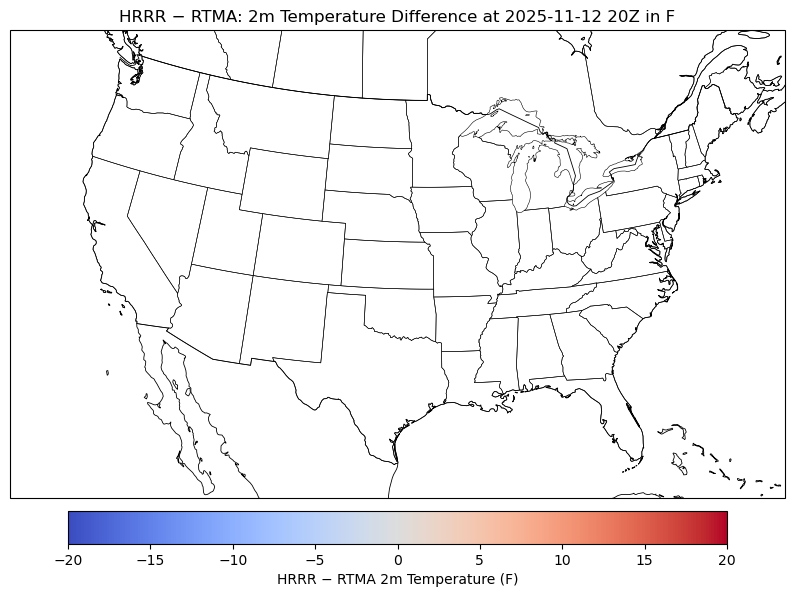

In [111]:
print(tempdiff_f)

# 2) Use HRRR lon/lat + wrap
lon = ds_hrrr["longitude"]
lat = ds_hrrr["latitude"]
lon = xr.where(lon > 180, lon - 360, lon)

# 3) Make a Cartopy map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95))  # pick your map proj
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.coastlines(resolution="50m", linewidth=0.6)

# 4) Plot (coordinates are lon/lat centers)
pc = ccrs.PlateCarree()
p = ax.pcolormesh(
    lon, lat, tempdiff_f,
    cmap="coolwarm",
    transform=pc,         # data coords
    shading="nearest",     # treat lon/lat as cell centers
    vmin=-20, vmax=20
)

cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.02, shrink=0.85)
cb.set_label("HRRR − RTMA 2m Temperature (F)")
ax.set_title("HRRR − RTMA: 2m Temperature Difference at " + str(date) + " " + str(displayhour) + "Z in F")
plt.show()